2025-06-24 02:28:39,385 - INFO - --- Starting Experiment 1: Hidden State Drift over Training ---
2025-06-24 02:28:39,387 - INFO - Loading model: spatial_model/checkpoint-4471


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-06-24 02:28:40,061 - INFO - Loading model: spatial_model/checkpoint-8942
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored:

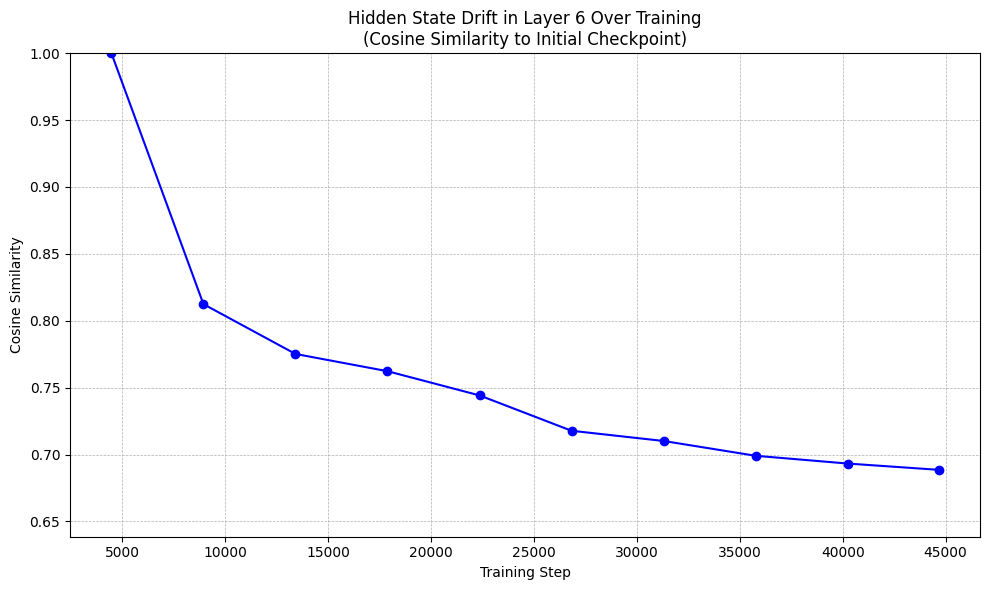

2025-06-24 02:28:45,975 - INFO - --- Starting Experiment 2: Spatial Correlation vs. Context Length ---
2025-06-24 02:28:45,976 - INFO - Loading model: spatial_model/checkpoint-44659
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-06-24 02:28:48,111 - INFO - Context length=10, Avg. Pearson correlation=0.3196 (from 200 runs)
2025-06-24 02:28:49,705 - INFO - Context length=20, Avg. Pearson correlation=0.2845 (from 200 runs)
2025-06-24 02:28:51,431 - INFO - Context lengt

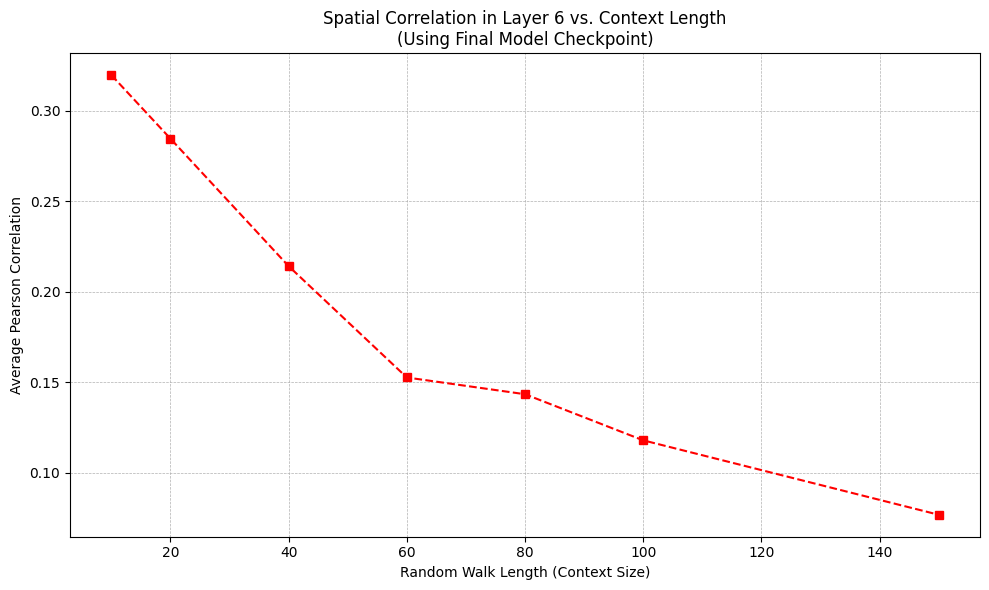

In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import random
import string
import networkx as nx
import logging

# --- Setup and Configuration ---
# Suppress verbose logging for a cleaner output
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define model checkpoints from the first script
CHECKPOINT_STEPS = [4471, 8942, 13413, 17884, 22355, 26826, 31297, 35768, 40239, 44659]
MODEL_BASE_PATH = "spatial_model/checkpoint-{}"
FINAL_MODEL_PATH = MODEL_BASE_PATH.format(CHECKPOINT_STEPS[-1])
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 6 # The specific layer we are interested in

# --- Helper Functions (adapted from the second script) ---

def generate_name(k=2):
    """Generates a short, random name for a node."""
    return ''.join(random.choices(string.ascii_lowercase, k=k))

def get_grid_graph_3x3(nodes=None):
    """Creates a 3x3 NetworkX grid graph."""
    if nodes is None:
        nodes = [generate_name() for _ in range(9)]
    G = nx.DiGraph()
    # Add nodes and edges with direction attributes
    for i in range(3):
        for j in range(3):
            node_idx = i * 3 + j
            if j < 2: # East-West edges
                G.add_edge(nodes[node_idx], nodes[node_idx + 1], direction='R')
                G.add_edge(nodes[node_idx + 1], nodes[node_idx], direction='L')
            if i < 2: # North-South edges
                G.add_edge(nodes[node_idx], nodes[node_idx + 3], direction='D')
                G.add_edge(nodes[node_idx + 3], nodes[node_idx], direction='U')
    return G, nodes

def build_positions_3x3(node_names):
    """Builds a dictionary mapping node names to (row, col) coordinates."""
    return {node_names[i]: (i // 3, i % 3) for i in range(len(node_names))}

def generate_long_random_walk(G, walk_length=50):
    """Generates a random walk of a given length on the graph."""
    nodes = list(G.nodes)
    current_node = random.choice(nodes)
    walk = [current_node]
    while len(walk) < walk_length:
        neighbors = list(G.successors(current_node))
        if not neighbors: break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node
    return walk

def walk_to_string(walk, G):
    """Converts a walk path into a string prompt."""
    tokens = []
    for i in range(len(walk) - 1):
        node1, node2 = walk[i], walk[i+1]
        direction = G.edges[(node1, node2)]['direction']
        tokens.extend([node1, direction])
    tokens.append(walk[-1])
    return " ".join(tokens)

class GPTLayerWrapper:
    """A wrapper to handle model loading and hidden state extraction for a specific layer."""
    def __init__(self, model_path):
        logging.info(f"Loading model: {model_path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.model = GPT2LMHeadModel.from_pretrained(model_path, output_hidden_states=True).to(DEVICE)
        self.model.eval()

    def get_layer_representation(self, prompt, layer):
        """Gets the representation for a prompt from a single layer."""
        tokens = self.tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = self.model(**tokens)
            # We take the mean of all token representations in the specified layer
            return torch.mean(outputs.hidden_states[layer][0], dim=0).cpu().numpy()

    def get_node_embeddings_from_layer(self, prompt, node_names, layer):
        """Extracts average embeddings for a list of node names from a specific layer."""
        enc = self.tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True, truncation=True)
        offsets = enc.pop("offset_mapping")[0].tolist()
        
        with torch.no_grad():
            outputs = self.model(**enc.to(DEVICE))
            hidden_states = outputs.hidden_states[layer].squeeze(0).cpu().numpy()

        loc_means = {}
        for loc in node_names:
            found_vecs = []
            start = 0
            while True:
                idx = prompt.find(loc, start)
                if idx == -1: break
                span_start, span_end = idx, idx + len(loc)
                start = idx + 1
                
                # Gather embeddings for the span
                overlap_vecs = [hidden_states[i] for i, (s, e) in enumerate(offsets) if not (e <= span_start or s >= span_end)]
                if overlap_vecs:
                    found_vecs.append(np.mean(overlap_vecs, axis=0))
            
            if found_vecs:
                loc_means[loc] = np.mean(found_vecs, axis=0)
        return loc_means

def calc_pearson_correlation(node_names, loc_mean_repr, positions):
    """Calculates Pearson correlation between representational and grid distances."""
    recognized = [n for n in node_names if n in loc_mean_repr]
    if len(recognized) < 3: return float('nan')

    man_distances, rep_distances = [], []
    for i in range(len(recognized)):
        for j in range(i + 1, len(recognized)):
            u, v = recognized[i], recognized[j]
            r1, c1 = positions[u]
            r2, c2 = positions[v]
            man_dist = abs(r1 - r2) + abs(c1 - c2)
            rep_dist = np.linalg.norm(loc_mean_repr[u] - loc_mean_repr[v])
            man_distances.append(man_dist)
            rep_distances.append(rep_dist)
    
    if len(man_distances) < 2: return float('nan')
    return pearsonr(man_distances, rep_distances)[0]

# --- Experiment 1: Hidden State Drift Over Training (Layer 6) ---

logging.info("--- Starting Experiment 1: Hidden State Drift over Training ---")
query_prompt = "MODE: Shortest, START: apple, END: orange, PATH: apple R banana D grape"
reps_over_training_layer6 = []

for step in CHECKPOINT_STEPS:
    model_path = MODEL_BASE_PATH.format(step)
    wrapper = GPTLayerWrapper(model_path)
    rep = wrapper.get_layer_representation(query_prompt, layer=LAYER_IDX)
    reps_over_training_layer6.append(rep)
    del wrapper, rep
    torch.cuda.empty_cache()

# Calculate similarity to the initial checkpoint
initial_rep = reps_over_training_layer6[0].reshape(1, -1)
similarities = [cosine_similarity(initial_rep, rep.reshape(1, -1))[0, 0] for rep in reps_over_training_layer6]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(CHECKPOINT_STEPS, similarities, marker='o', linestyle='-', color='b')
plt.title(f'Hidden State Drift in Layer {LAYER_IDX} Over Training\n(Cosine Similarity to Initial Checkpoint)')
plt.xlabel('Training Step')
plt.ylabel('Cosine Similarity')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(min(0.8, min(similarities) - 0.05), 1.0)
plt.tight_layout()
plt.show()

# --- Experiment 2: Spatial Correlation vs. Context Length (Layer 6) ---

logging.info("--- Starting Experiment 2: Spatial Correlation vs. Context Length ---")
context_lengths = [10, 20, 40, 60, 80, 100, 150]
n_runs = 200 # Number of runs to average for each context length
avg_correlations = []

# Load the final model
final_wrapper = GPTLayerWrapper(FINAL_MODEL_PATH)

for length in context_lengths:
    run_corrs = []
    for i in range(n_runs):
        G, node_names = get_grid_graph_3x3()
        positions = build_positions_3x3(node_names)
        walk = generate_long_random_walk(G, walk_length=length)
        prompt = walk_to_string(walk, G)
        
        loc_mean_repr = final_wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
        corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
        
        if not np.isnan(corr):
            run_corrs.append(corr)
    
    mean_corr = np.mean(run_corrs) if run_corrs else float('nan')
    avg_correlations.append(mean_corr)
    logging.info(f"Context length={length}, Avg. Pearson correlation={mean_corr:.4f} (from {len(run_corrs)} runs)")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(context_lengths, avg_correlations, marker='s', linestyle='--', color='r')
plt.title(f'Spatial Correlation in Layer {LAYER_IDX} vs. Context Length\n(Using Final Model Checkpoint)')
plt.xlabel('Random Walk Length (Context Size)')
plt.ylabel('Average Pearson Correlation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# %%

2025-06-24 02:34:12,057 - INFO - --- Starting Experiment: Spatial Correlation Over Training ---
2025-06-24 02:34:12,058 - INFO - Loading model: spatial_model/checkpoint-4471


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-06-24 02:34:14,631 - INFO - Checkpoint 4471: Avg. Pearson Correlation = 0.0257 (from 200 runs)
2025-06-24 02:34:14,653 - INFO - Loading model: spatial_model/checkpoint-8942
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMER

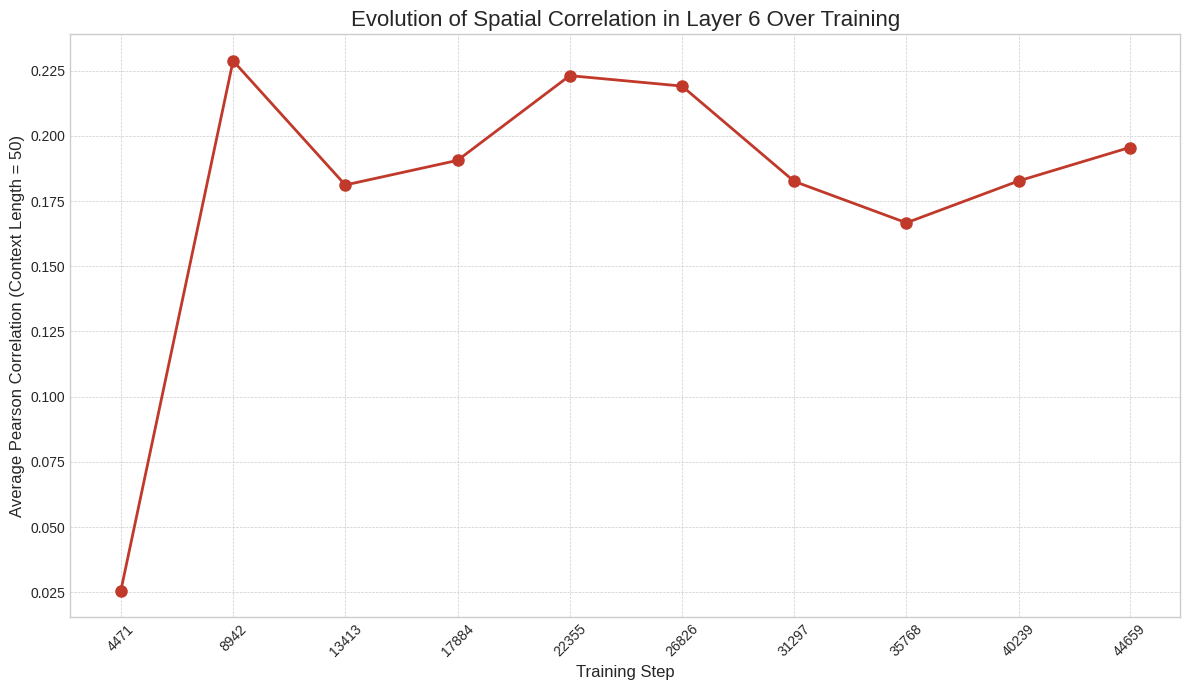

In [5]:
set_seed(42)

# --- Parameters for the Experiment ---
CHECKPOINT_STEPS = [4471, 8942, 13413, 17884, 22355, 26826, 31297, 35768, 40239, 44659]
MODEL_BASE_PATH = "spatial_model/checkpoint-{}"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 6                # The specific layer we are analyzing
WALK_LENGTH = 50             # Fixed context length for a fair comparison across checkpoints
N_RUNS = 200                  # Number of trials to average for each checkpoint to get a stable score

#

def calc_pearson_correlation(node_names, loc_mean_repr, positions):
    """Calculates Pearson correlation between representational and grid distances."""
    recognized = [n for n in node_names if n in loc_mean_repr]
    if len(recognized) < 3: return float('nan')
    man_distances, rep_distances = [], []
    for i in range(len(recognized)):
        for j in range(i + 1, len(recognized)):
            u, v = recognized[i], recognized[j]
            r1, c1 = positions[u]
            r2, c2 = positions[v]
            man_dist = abs(r1 - r2) + abs(c1 - c2)
            rep_dist = np.linalg.norm(loc_mean_repr[u] - loc_mean_repr[v])
            man_distances.append(man_dist)
            rep_distances.append(rep_dist)
    if len(man_distances) < 2: return float('nan')
    return pearsonr(man_distances, rep_distances)[0]

# --- Main Experiment: Spatial Correlation Over Training ---

logging.info("--- Starting Experiment: Spatial Correlation Over Training ---")

correlations_over_training = []

for step in CHECKPOINT_STEPS:
    model_path = MODEL_BASE_PATH.format(step)
    wrapper = GPTLayerWrapper(model_path)
    
    run_corrs_for_checkpoint = []
    for i in range(N_RUNS):
        G, node_names = get_grid_graph_3x3()
        positions = build_positions_3x3(node_names)
        walk = generate_long_random_walk(G, walk_length=WALK_LENGTH)
        prompt = walk_to_string(walk, G)
        
        loc_mean_repr = wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
        corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
        
        if not np.isnan(corr):
            run_corrs_for_checkpoint.append(corr)
    
    mean_corr = np.mean(run_corrs_for_checkpoint) if run_corrs_for_checkpoint else float('nan')
    correlations_over_training.append(mean_corr)
    logging.info(f"Checkpoint {step}: Avg. Pearson Correlation = {mean_corr:.4f} (from {len(run_corrs_for_checkpoint)} runs)")
    
    # Clean up memory
    del wrapper
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Plotting the Results ---

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

plt.plot(CHECKPOINT_STEPS, correlations_over_training, marker='o', linestyle='-', color='#c0392b', markersize=8, linewidth=2)

plt.title(f'Evolution of Spatial Correlation in Layer {LAYER_IDX} Over Training', fontsize=16)
plt.xlabel('Training Step', fontsize=12)
plt.ylabel(f'Average Pearson Correlation (Context Length = {WALK_LENGTH})', fontsize=12)

plt.xticks(CHECKPOINT_STEPS, rotation=45)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# %%






